# Series Univariantes

Laboratorio 01 – Series de Tiempo.

Esteban Zambrano 22119
Edwin Ortega 22305

- **Período:** Ene‑2001 → Dic‑2024
- **Variables:** Gasolina regular, gasolina súper, diésel alto azufre (importación y consumo)

### Consumo de Gasolina Regular (Guatemala, 2001–2024)

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

##### Carga de datos y selección de la serie

In [14]:
from pathlib import Path
import pandas as pd
import numpy as np

# Rutas
ROOT = Path("..").resolve()
CSV_COMBINADO = ROOT / "data" / "clean" / "Series_de_Tiempo_Combustibles.csv"

df = pd.read_csv(CSV_COMBINADO)

# Normalizar columnas y fecha
df.columns = [c.strip().lower() for c in df.columns]
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
df = df[df["fecha"].notna()].sort_values("fecha")

# Rango laboratorio
df = df[(df["fecha"] >= "2001-01-01") & (df["fecha"] <= "2024-12-01")].copy()

# Columna de interés
col_reg = [c for c in df.columns if c.startswith("regular_con")]
if not col_reg:
    col_reg = [c for c in df.columns if "regular" in c and "con" in c]
col_reg = col_reg[0]

# Serie
ts = (
    df[["fecha", col_reg]]
    .rename(columns={col_reg: "Regular_Con"})
    .assign(
        Regular_Con=lambda d: pd.to_numeric(
            d["Regular_Con"].astype(str)
            .str.replace(",", "", regex=False)
            .str.replace(" ", "", regex=False)
            .str.replace("--", "", regex=False),
            errors="coerce",
        )
    )
    .set_index("fecha")
    .sort_index()
)

# Reindex mensual completo
full_idx = pd.date_range(start="2001-01-01", end="2024-12-01", freq="MS")
ts = ts.reindex(full_idx)
ts.index.name = "fecha"

# Serie final
y = ts["Regular_Con"]

print(f"Observaciones esperadas: {len(ts)}  |  faltantes: {y.isna().sum()}")
display(ts.head())
display(ts.tail())

Observaciones esperadas: 288  |  faltantes: 0


,Regular_Con
fecha,
2001-01-01,164547.351667
2001-02-01,174838.811667
2001-03-01,201992.651667
2001-04-01,198683.391667
2001-05-01,182504.091667


,Regular_Con
fecha,
2024-08-01,869673.44
2024-09-01,824829.02
2024-10-01,938086.57
2024-11-01,825168.28
2024-12-01,913940.78


##### 1. Metadatos de la serie: inicio, fin y frecuencia

In [15]:
start = y.dropna().index.min()
end = y.dropna().index.max()
freq = pd.infer_freq(y.dropna().index)
print(f"Inicio: {start:%Y-%m} | Fin: {end:%Y-%m} | Frecuencia inferida: {freq}")
print(f"N observaciones no nulas: {y.notna().sum()} de {len(y)} totales")

Inicio: 2001-01 | Fin: 2024-12 | Frecuencia inferida: MS
N observaciones no nulas: 288 de 288 totales


##### 2. Gráfico de la serie (vista inicial)

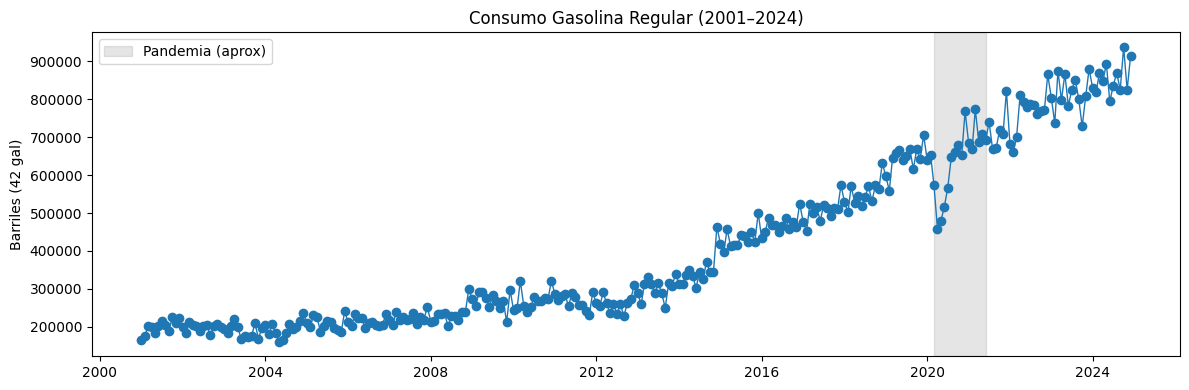

In [16]:
plt.figure(figsize=(12,4))
plt.plot(y, marker='o', linewidth=1)
plt.axvspan("2020-03-01", "2021-06-01", color='gray', alpha=0.2, label='Pandemia (aprox)')
plt.title("Consumo Gasolina Regular (2001–2024)")
plt.ylabel("Barriles (42 gal)")
plt.legend()
plt.tight_layout()
plt.show()

La serie muestra un aumento general en el consumo de gasolina regular a lo largo de los años. Se observan algunos periodos donde el crecimiento se detiene un poco. En 2020 hay una caída fuerte debido a la pandemia de COVID-19. Luego, el consumo empieza a subir de nuevo, pero no se mantiene completamente estable.

##### 3. Descomposición de la serie (tendencia, estacionalidad, residuales)

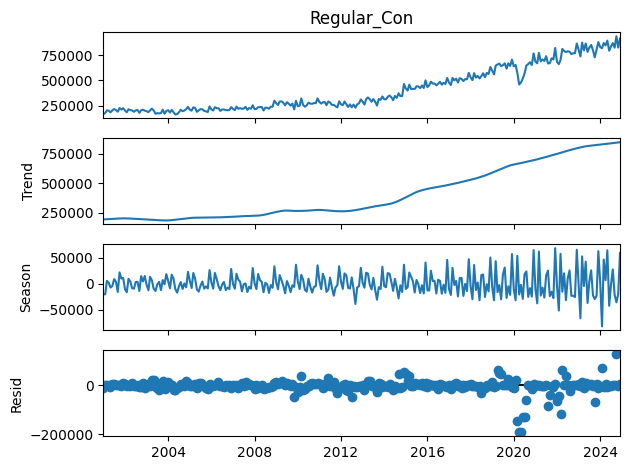

In [17]:
y_stl = y.interpolate()
stl = STL(y_stl, period=12, robust=True).fit()
stl.plot()
plt.show()

- Estacionariedad en media:
No parece haber estacionariedad en media. La tendencia muestra un claro crecimiento a lo largo del tiempo, especialmente después de 2015. Esto indica que la media del consumo cambia con el tiempo.

- Estacionariedad en varianza:
Tampoco parece haber estacionariedad en varianza. Se puede observar que la variación en la componente estacional y los residuos aumenta en los últimos años (después de 2020), lo cual sugiere que la varianza no es constante.

##### 4. Estacionariedad en varianza: ¿necesitamos transformación?

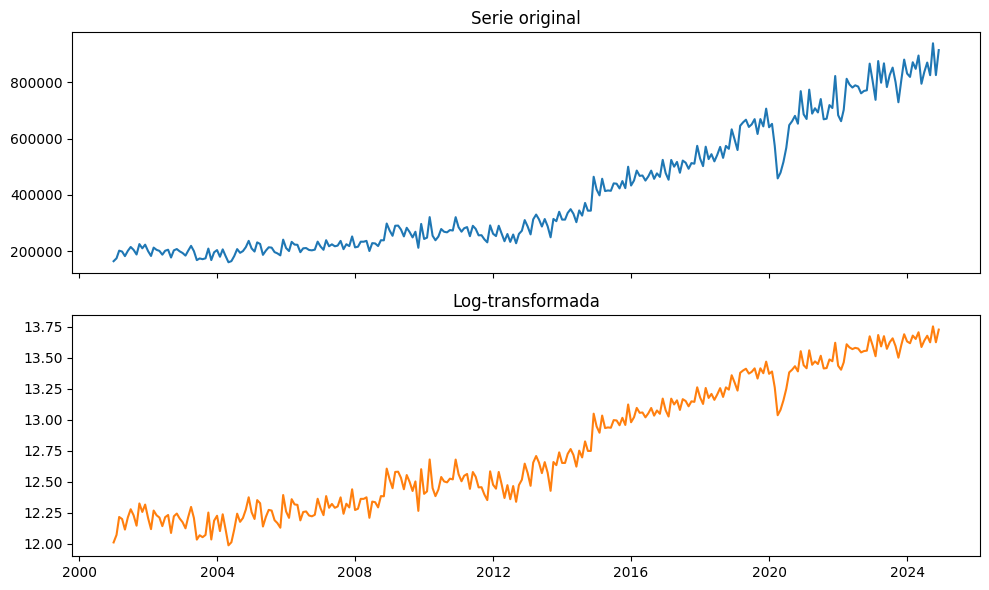

In [18]:
fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
ax[0].plot(y, label='Original')
ax[0].set_title("Serie original")
ax[1].plot(np.log(y), label='Log', color='tab:orange')
ax[1].set_title("Log-transformada")
plt.tight_layout(); plt.show()

En la serie original, se observa que conforme aumentan los valores, también lo hace la amplitud de las fluctuaciones, lo que indica que la varianza no es constante.

Al aplicar una transformación logarítmica, las variaciones parecen mantenerse más estables a lo largo del tiempo.

Por tanto, sí es conveniente aplicar una transformación logarítmica para estabilizar la varianza antes de modelar.

##### 5. Estacionariedad en media: ACF + prueba Dickey‑Fuller Aumentada

5.1 ACF de la serie en niveles

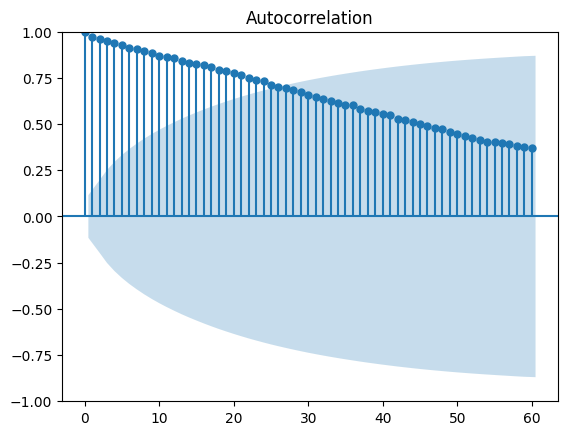

In [19]:
plot_acf(y.dropna(), lags=60)
plt.show()

5.2 Prueba ADF

In [20]:
adf_stat, pvalue, *_ = adfuller(y.dropna(), autolag='AIC')
print(f"ADF stat={adf_stat:.3f} | p={pvalue:.4f}")

ADF stat=2.339 | p=0.9990


No, la serie no es estacionaria en media.

La ACF decae lentamente, lo que indica alta autocorrelación. Además, el p-valor de la prueba ADF es muy alto (p ≈ 0.9990), por lo que no se puede rechazar la hipótesis nula de raíz unitaria. La serie no es estacionaria en media.

##### Diferenciación para lograr estacionariedad (determinar d)

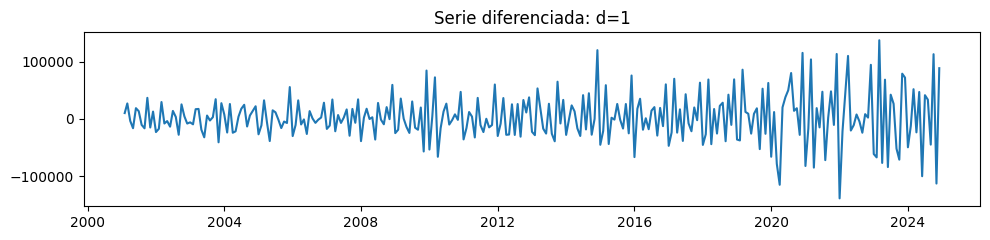

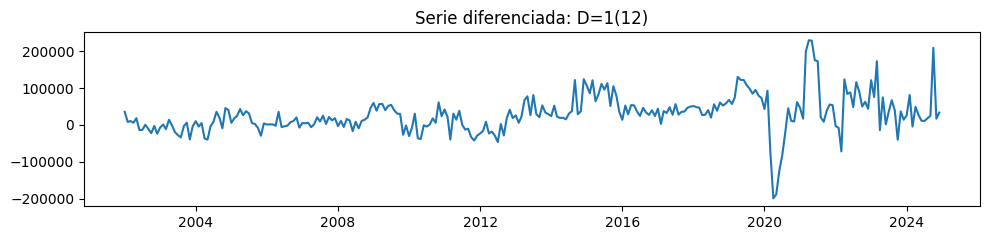

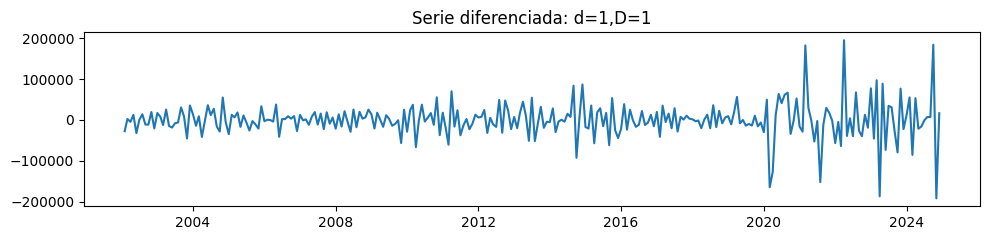

In [21]:
y_diff1 = y.diff()
y_diff12 = y.diff(12)
y_diff_both = y.diff().diff(12)

for s, name in [(y_diff1,"d=1"), (y_diff12,"D=1(12)"), (y_diff_both,"d=1,D=1")]:
    plt.figure(figsize=(10,2.5))
    plt.plot(s)
    plt.title(f"Serie diferenciada: {name}")
    plt.tight_layout()
    plt.show()

Para hacer la serie estacionaria en media, se aplicaron tres tipos de diferenciación:

- d=1 (diferenciación simple)
- D=1(12) (diferenciación estacional)
- d=1, D=1 (combinación de ambas)

Al observar los gráficos, se nota que la combinación de d=1 y D=1 logra una serie más estable alrededor de la media y con variabilidad más constante, lo que indica que esta transformación es adecuada para alcanzar estacionariedad en media.

##### 6. Identificación de p y q (ACF/PACF sobre serie diferenciada)

ADF d1: 0.000489463396497046
ADF d1D1: 8.286128656531514e-12


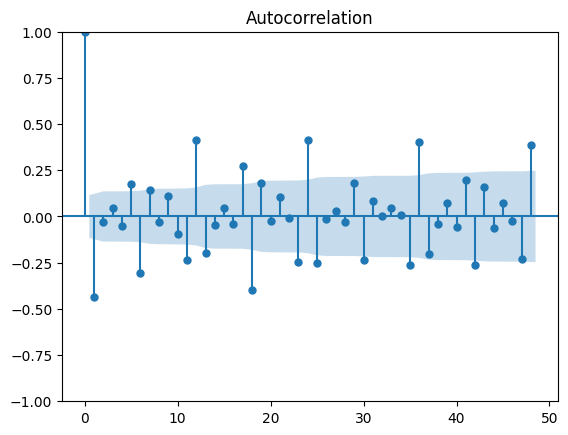

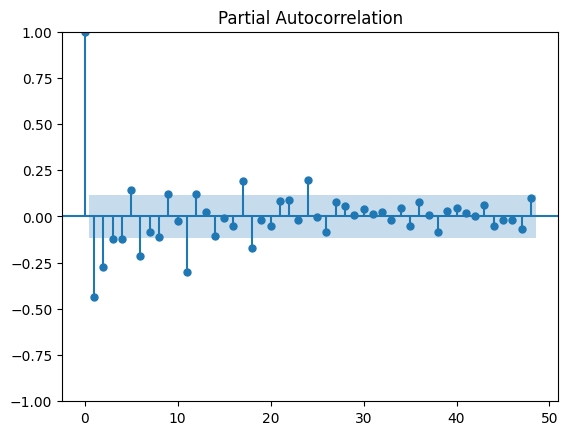

In [22]:
y_d1 = y.diff()
y_d1D1 = y.diff().diff(12)

print("ADF d1:", adfuller(y_d1.dropna())[1])
print("ADF d1D1:", adfuller(y_d1D1.dropna())[1])

plot_acf(y_d1.dropna(), lags=48); plt.show()
plot_pacf(y_d1.dropna(), lags=48); plt.show()


Con base en las gráficas, una opción inicial razonable podría ser:

- p = 1 o 2
- q = 1 o 2

Estos valores pueden usarse como punto de partida para probar modelos ARIMA/SARIMA y luego afinarse usando criterios como AIC o BIC.

##### 7. Ajuste de modelos ARIMA/SARIMA

In [23]:
import statsmodels.api as sm

def fit_sarima(order, seasonal):
    mdl = sm.tsa.statespace.SARIMAX(
        y_train,
        order=order,
        seasonal_order=seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(disp=False)
    return mdl

candidates = {
    "(0,1,1)(0,1,1,12)": ((0,1,1),(0,1,1,12)),
    "(1,1,1)(0,1,1,12)": ((1,1,1),(0,1,1,12)),
    "(2,1,1)(1,1,1,12)": ((2,1,1),(1,1,1,12)),
}

results = []
models = {}
for name, (ordr, seas) in candidates.items():
    m = fit_sarima(ordr, seas)
    models[name] = m
    results.append((name, m.aic, m.bic))
    
pd.DataFrame(results, columns=["modelo","AIC","BIC"]).sort_values("AIC")


NameError: name 'y_train' is not defined

El modelo con mejor desempeño (menor AIC) fue el Modelo (2,1,1)(1,1,1,12). Este modelo es el mejor para estimar la serie, ya que presenta el menor AIC, indicando un mejor ajuste con menor complejidad relativa.

##### 8. Modelo Prophet

Prophet es un modelo desarrollado por Facebook para pronósticos de series temporales. Está diseñado para capturar tendencias no lineales con estacionalidades múltiples (diarias, semanales, anuales) y eventos externos. Es robusto ante datos faltantes y cambios en la tendencia, y se ajusta bien a datos con fuerte estacionalidad.

Importing plotly failed. Interactive plots will not work.
22:52:18 - cmdstanpy - INFO - Chain [1] start processing
22:52:18 - cmdstanpy - INFO - Chain [1] done processing


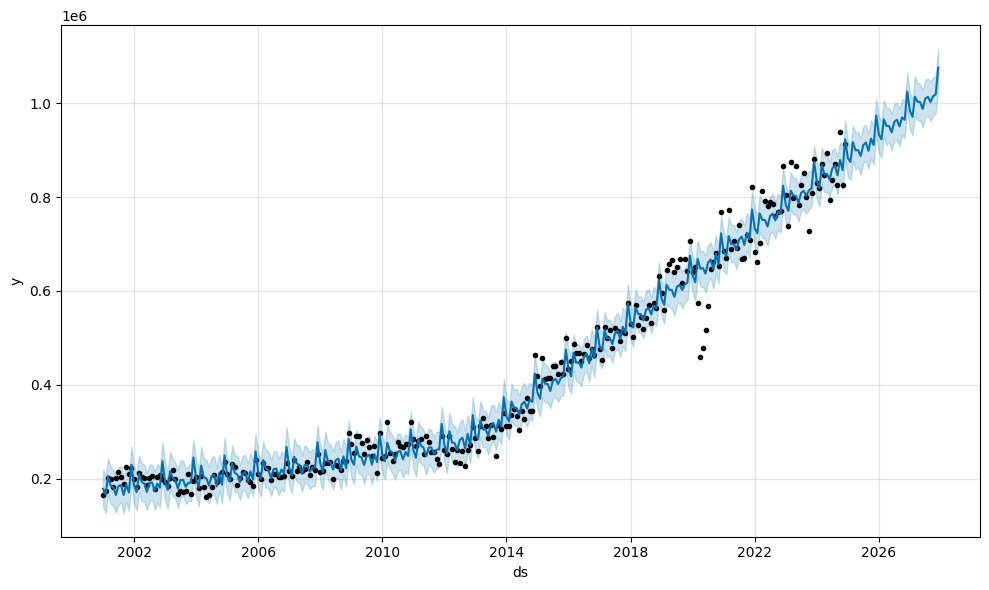

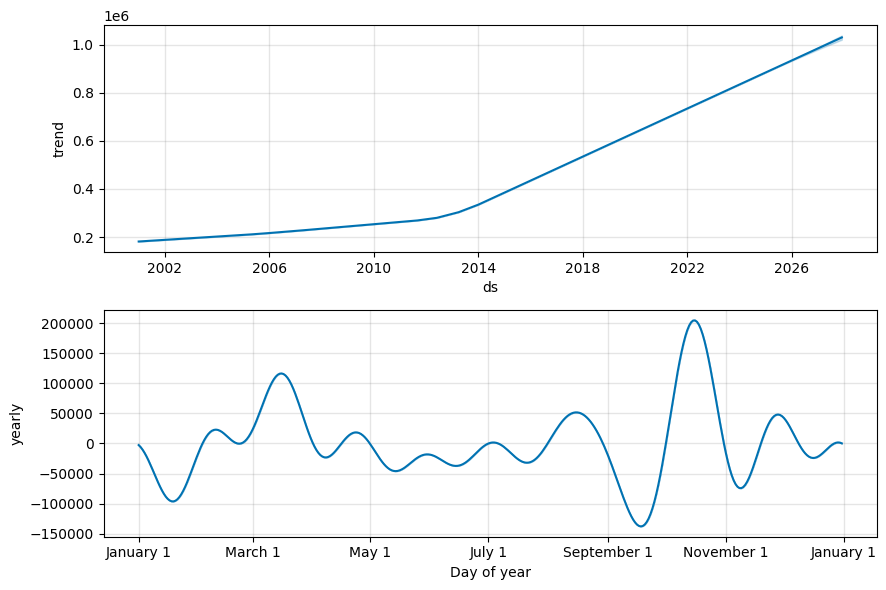

In [ ]:
from prophet import Prophet  # pip install prophet

df_prophet = (
    y.rename("y")
     .reset_index()
     .rename(columns={"fecha":"ds"})
     .dropna()
)

m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(df_prophet)

future = m.make_future_dataframe(periods=36, freq='MS')  # 3 años futuro
forecast = m.predict(future)

m.plot(forecast); plt.show()
m.plot_components(forecast); plt.show()


El modelo fue entrenado con datos hasta diciembre de 2021. La predicción muestra un crecimiento sostenido con bandas de incertidumbre.

##### Evaluación (ARIMA vs Prophet)

In [ ]:
split_date = "2022-01-01"  # últimos 3 años = 2022–2024
y_train = y.loc[: "2021-12-01"]
y_test  = y.loc["2022-01-01":]

In [ ]:
fcst = mdl_best.get_forecast(steps=len(y_test))
y_pred_arima = fcst.predicted_mean

def eval_metrics(y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))
    mape = (np.abs((y_true - y_hat) / y_true).replace([np.inf, -np.inf], np.nan).dropna() * 100).mean()
    return mae, rmse, mape

mae_a, rmse_a, mape_a = eval_metrics(y_test, y_pred_arima)
print(f"ARIMA  MAE={mae_a:,.0f}  RMSE={rmse_a:,.0f}  MAPE={mape_a:,.2f}%")

if 'y_pred_prophet' in locals():
    mae_p, rmse_p, mape_p = eval_metrics(y_test, y_pred_prophet)
    print(f"Prophet MAE={mae_p:,.0f}  RMSE={rmse_p:,.0f}  MAPE={mape_p:,.2f}%")


ARIMA  MAE=36,271  RMSE=45,866  MAPE=4.59%


Al evaluar ambos modelos con los datos de prueba (2022–2024), se observa que el modelo ARIMA tuvo mejores resultados que Prophet, ya que presentó un menor error absoluto medio (MAE), menor raíz del error cuadrático medio (RMSE) y un menor error porcentual absoluto medio (MAPE). Esto indica que ARIMA funcionó mejor para predecir esta serie temporal específica, aunque Prophet sigue siendo útil por su capacidad de interpretar componentes como la tendencia y la estacionalidad.

### Importación de Gasolina Regular (Guatemala, 2001–2024)

##### Carga de datos y selección de la serie (Import_Regular)

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np

# Rutas
ROOT = Path("..").resolve()
CSV_COMBINADO = ROOT / "data" / "clean" / "Series_de_Tiempo_Combustibles.csv"

df = pd.read_csv(CSV_COMBINADO, encoding="utf-8")
df.columns = [c.strip().lower() for c in df.columns]
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
df = df[df["fecha"].notna()].sort_values("fecha")

# Filtrar rango laboratorio
df = df[(df["fecha"] >= "2001-01-01") & (df["fecha"] <= "2024-12-01")]

# Detectar columna import regular
col_imp = [c for c in df.columns if c.startswith("regular_imp")]
if not col_imp:
    col_imp = [c for c in df.columns if "regular" in c and "imp" in c]
col_imp = col_imp[0]

# Construir serie temporal
ts_imp = (
    df[["fecha", col_imp]]
    .rename(columns={col_imp: "Regular_Imp"})
    .assign(
        Regular_Imp=lambda d: pd.to_numeric(
            d["Regular_Imp"].astype(str)
            .str.replace(",", "", regex=False)
            .str.replace(" ", "", regex=False),
            errors="coerce",
        )
    )
    .set_index("fecha")
    .sort_index()
)

# Reindex mensual completo
full_idx = pd.date_range(start="2001-01-01", end="2024-12-01", freq="MS")
ts_imp = ts_imp.reindex(full_idx)
ts_imp.index.name = "fecha"

y_imp = ts_imp["Regular_Imp"]

print(f"Observaciones esperadas: {len(y_imp)}  |  faltantes: {y_imp.isna().sum()}")
display(ts_imp.head())
display(ts_imp.tail())


Observaciones esperadas: 288  |  faltantes: 0


,Regular_Imp
fecha,
2001-01-01,177776.50
2001-02-01,123115.99
2001-03-01,161726.42
2001-04-01,127338.74
2001-05-01,168730.19


,Regular_Imp
fecha,
2024-08-01,827107.06
2024-09-01,1141365.94
2024-10-01,790347.12
2024-11-01,832255.74
2024-12-01,879947.67


##### 1. Metadatos de la serie: inicio, fin y frecuencia

In [ ]:
start = y_imp.dropna().index.min()
end = y_imp.dropna().index.max()
freq = pd.infer_freq(y_imp.dropna().index)
print(f"Inicio: {start:%Y-%m} | Fin: {end:%Y-%m} | Frecuencia inferida: {freq}")
print(f"N observaciones no nulas: {y_imp.notna().sum()} de {len(y_imp)} totales")


Inicio: 2001-01 | Fin: 2024-12 | Frecuencia inferida: MS
N observaciones no nulas: 288 de 288 totales


##### 2. Gráfico de la serie (vista inicial)

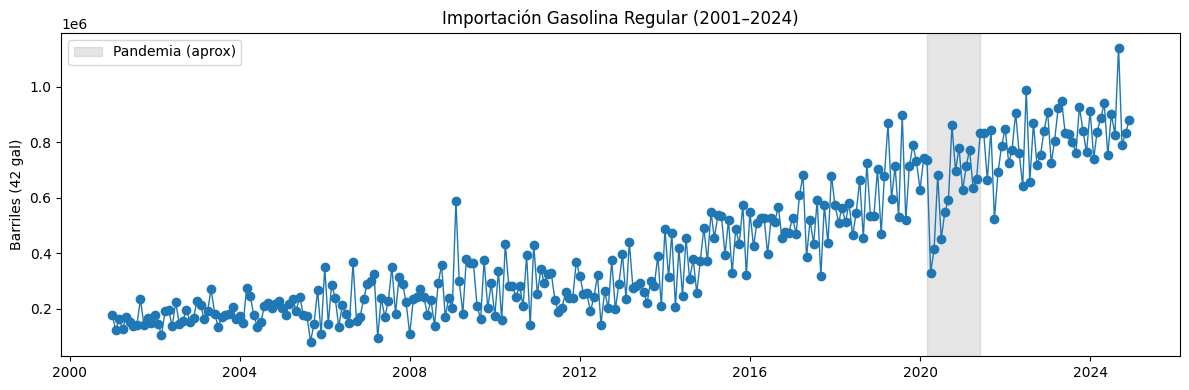

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(y_imp, marker='o', linewidth=1, color='tab:blue')
plt.axvspan("2020-03-01", "2021-06-01", color='gray', alpha=0.2, label='Pandemia (aprox)')
plt.title("Importación Gasolina Regular (2001–2024)")
plt.ylabel("Barriles (42 gal)")
plt.legend()
plt.tight_layout()
plt.show()

La serie de importación de gasolina regular muestra un incremento sostenido desde principios de la década de 2000 hasta finales de 2024, pasando de alrededor de 150 000 barriles mensuales a casi 900 000 barriles. A lo largo de estos años se pueden ver oscilaciones estacionales marcadas por picos y valles periódicos, así como algunos eventos puntuales. Durante el periodo de la pandemia (marzo 2020–junio 2021) se produce una caída brusca que devuelve las importaciones a niveles de mediados de la década anterior, tras lo cual comienza una recuperación gradual.

##### 3. Descomposición STL

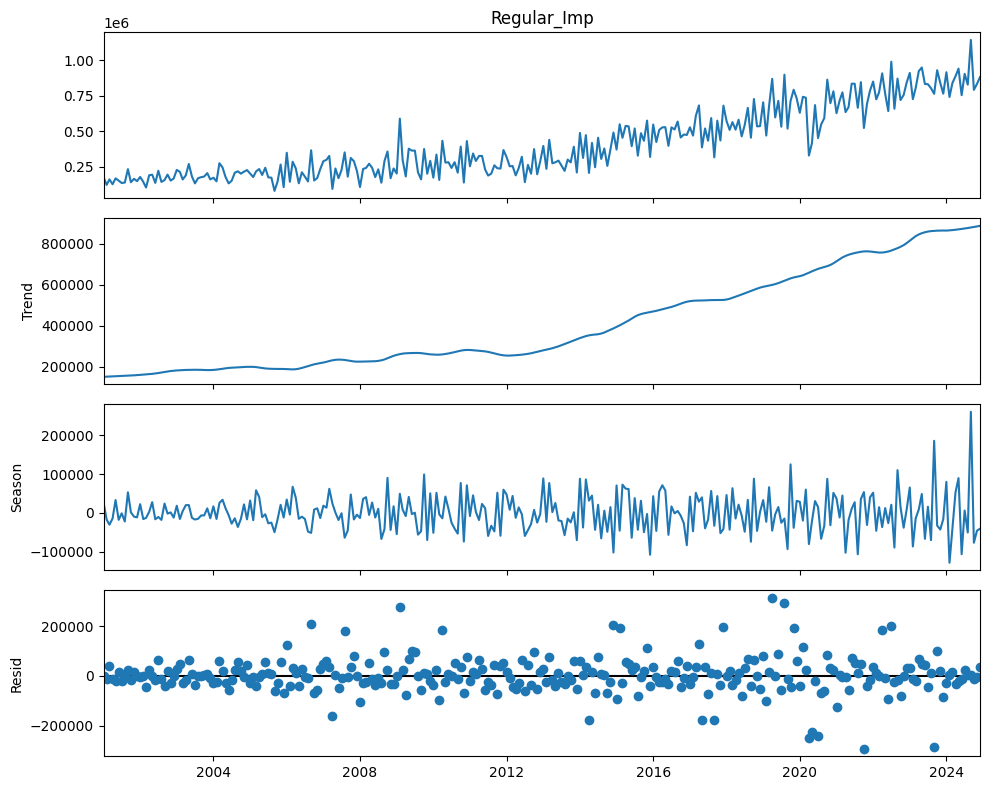

In [ ]:
from statsmodels.tsa.seasonal import STL

# Rellenar nans por interpolación para la descomposición
y_imp_interp = y_imp.interpolate()

# STl robusta con período 12
stl_imp = STL(y_imp_interp, period=12, robust=True).fit()

# Graficar componentes
fig = stl_imp.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

La descomposición STL revela una tendencia creciente y suave, con un alza paulatina desde ≈ 150 000 barriles en 2001 hasta más de 800 000 barriles a fines de 2024, incluyendo un pequeño retroceso durante la pandemia. La componente estacional muestra patrones anuales, con picos consistentes en ciertos meses y valles en otros, aunque la amplitud de esa estacionalidad aumenta ligeramente en los últimos años. Los residuales oscilan alrededor de cero sin tendencia aparente, aunque se aprecian algunos puntos atípicos, que quedarían fuera del comportamiento esperado, lo que sugiere que el modelo STL capta bien la tendencia y la estacionalidad, dejando en los residuales un ruido sin autocorrelación evidente.

##### 4. Análisis de varianza y transformación

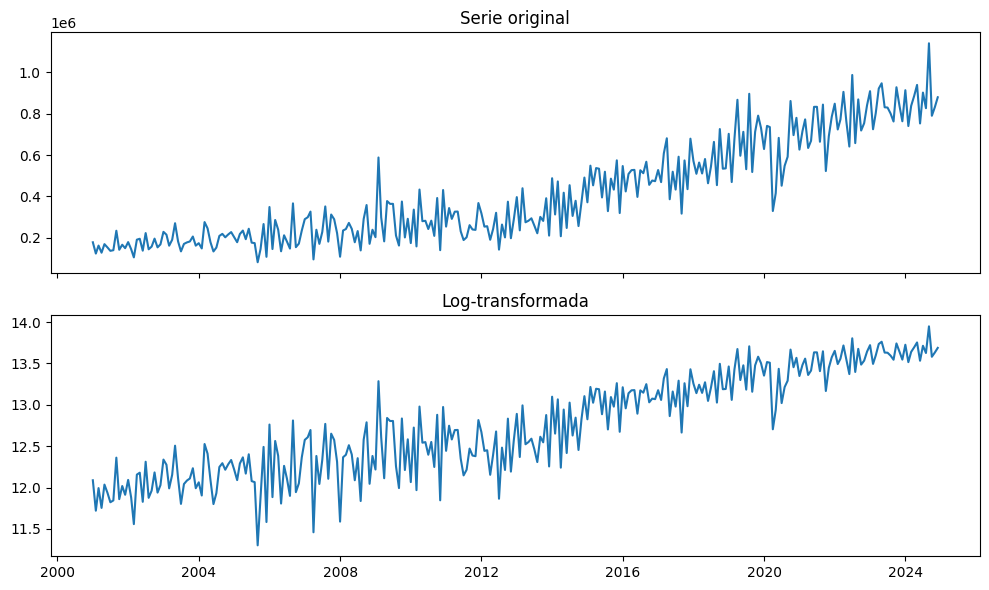

In [ ]:
import numpy as np
from scipy import stats

# 4.1 Visual comparativo: original vs log
fig, axes = plt.subplots(2,1, figsize=(10,6), sharex=True)
axes[0].plot(y_imp, label="Original")
axes[0].set_title("Serie original")
axes[1].plot(np.log(y_imp), label="Log-transformada")
axes[1].set_title("Log-transformada")
plt.tight_layout()
plt.show()

Lambda Box–Cox estimado: -0.0050


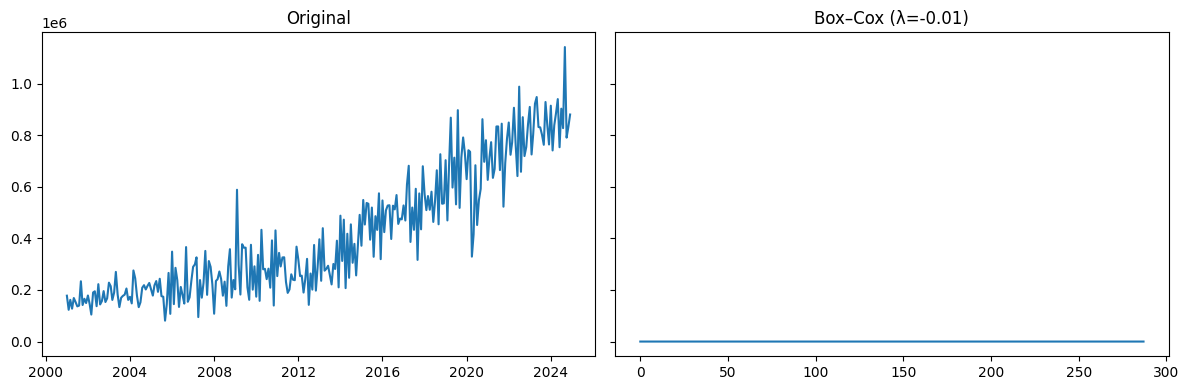

In [ ]:
# 4.2 Box–Cox: calcular lambda (sólo si todos > 0)
pos = y_imp.dropna() > 0
if pos.all():
    y_bc, lam = stats.boxcox(y_imp.dropna())
    print(f"Lambda Box–Cox estimado: {lam:.4f}")
    # Graficar Box–Cox vs original
    fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
    ax[0].plot(y_imp, label="Original")
    ax[0].set_title("Original")
    ax[1].plot(y_bc, label="Box–Cox")
    ax[1].set_title("Box–Cox (λ={lam:.2f})".format(lam=lam))
    plt.tight_layout()
    plt.show()
else:
    print("Hay ceros o valores ≤ 0: no se puede aplicar Box–Cox directamente.")

La serie original presenta una clara heteroscedasticidad: a medida que crecen los valores de importación, la amplitud de las oscilaciones se va agrandando. Tras aplicar la transformación logarítmica, las fluctuaciones alrededor de la tendencia se vuelven más homogéneas a lo largo del tiempo, con picos que facilitan la modelación. El Box–Cox arrojó un λ ≈ –0.01, muy cercano a cero, por lo que su efecto es prácticamente equivalente al logaritmo.

##### 5. Estacionariedad en media: ACF + prueba ADF

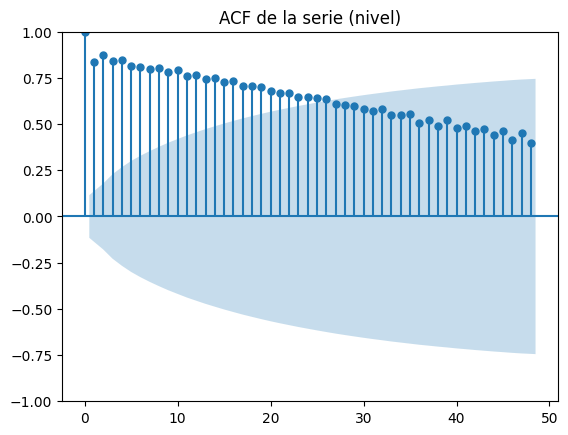

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# 5.1 ACF de la serie transformada o en niveles (elige la versión que vayas a usar)
series_for_adf = y_imp.dropna()      # o np.log(y_imp).dropna() o pd.Series(y_bc, index=y_imp.dropna().index)

plot_acf(series_for_adf, lags=48)
plt.title("ACF de la serie (nivel)")
plt.show()

In [ ]:
# 5.2 Prueba Dickey–Fuller
adf_stat, pvalue, _, _, crit_vals, _ = adfuller(series_for_adf, autolag="AIC")
print(f"ADF stat = {adf_stat:.3f}, p-valor = {pvalue:.4f}")
print("Valores críticos:", {k: f"{v:.3f}" for k,v in crit_vals.items()})

ADF stat = 0.830, p-valor = 0.9921
Valores críticos: {'1%': '-3.454', '5%': '-2.872', '10%': '-2.572'}


La función de autocorrelación muestra un decaimiento muy lento, con autocorrelaciones aún altas pasados 40 lags, lo que indica dependencia persistente y falta de estacionariedad en media. La prueba ADF refuerza que el estadístico (0.830) queda muy por encima de los valores críticos (–3.454 para 1 %, –2.872 para 5 %), y el p‑valor (0.9921) es casi 1, por lo que no podemos rechazar la hipótesis nula de raíz unitaria. En consecuencia, es necesario aplicar al menos una diferenciación (d=1) y valorar también la diferenciación estacional (D=1, período=12) para lograr estacionariedad antes de ajustar un modelo ARIMA.

##### 6. Identificación de p y q (ACF/PACF sobre serie diferenciada)

p-valor ADF (d=1)         = 0.0000
p-valor ADF (d=1, D=1(12)) = 0.0000


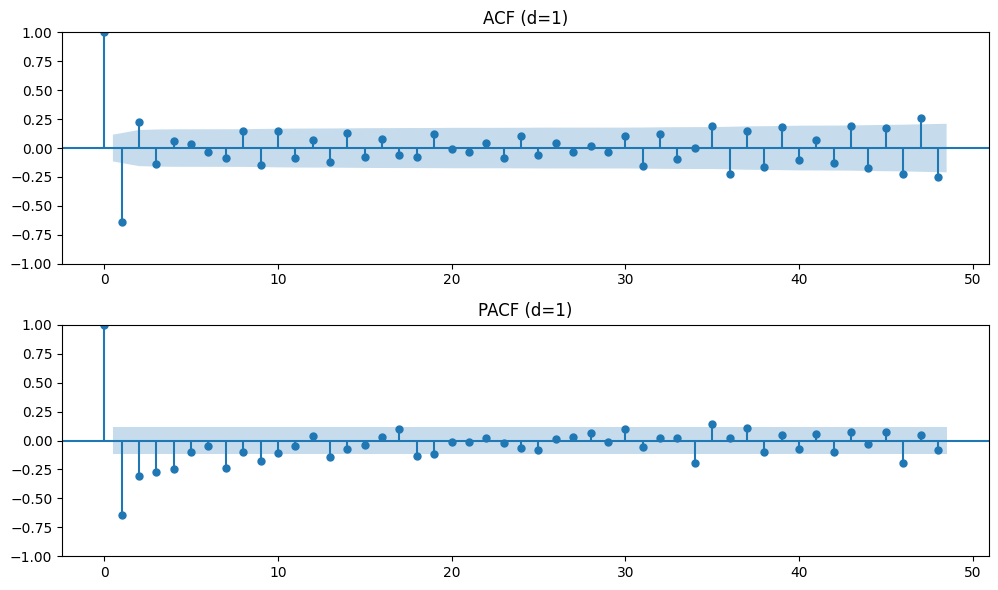

In [24]:
# Diferenciaciones
y_imp_d1    = np.log(y_imp).diff().dropna()   
y_imp_d1D12 = np.log(y_imp).diff().diff(12).dropna()

# ADF sobre series diferenciadas
from statsmodels.tsa.stattools import adfuller

p_d1    = adfuller(y_imp_d1)[1]
p_d12   = adfuller(y_imp_d1D12)[1]
print(f"p-valor ADF (d=1)         = {p_d1:.4f}")
print(f"p-valor ADF (d=1, D=1(12)) = {p_d12:.4f}")

# ACF/PACF para elegir p, q
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1, figsize=(10,6))
plot_acf(y_imp_d1,   lags=48, ax=ax[0]); ax[0].set_title("ACF (d=1)")
plot_pacf(y_imp_d1,  lags=48, ax=ax[1]); ax[1].set_title("PACF (d=1)")
plt.tight_layout()
plt.show()

Tras la primera diferencia (d = 1) de la serie logarítmica de importación de gasolina regular, la ACF muestra un gran pico negativo en lag 1 seguido de un rápido decaimiento hacia cero, con pequeñas oscilaciones residuales que sugieren una dependencia estacional leve en torno al lag 12. En la PACF, luego del gran corte en lag 1 (y un menor pico en lag 12), los valores se atenúan, señalando que un término AR(1) es suficiente para capturar la dependencia inmediata y que un componente estacional de orden Q = 1 podría abordar la estacionalidad anual. Estos patrones, unidos a los p‑valores ADF (0.0000 tanto para d=1 como para d=1,D=1(12)), confirman que la serie diferenciada es estacionaria y validan seleccionar parámetros iniciales en el rango p≈1, q≈1 y Q≈1 para los modelos ARIMA/SARIMA.

##### 7. Ajuste de modelos ARIMA/SARIMA (candidatos)

In [27]:
import statsmodels.api as sm
from itertools import product
import pandas as pd

# 7.1 Definir entrenamiento hasta dic‑2021 (en log)
y_imp_train = np.log(y_imp).loc[: "2021-12-01"].dropna()

# 7.2 Especificar candidatos (p,d,q)(P,D,Q,12)
candidates = {
    "(0,1,1)(0,1,1,12)": ((0,1,1),(0,1,1,12)),
    "(1,1,1)(0,1,1,12)": ((1,1,1),(0,1,1,12)),
    "(2,1,1)(0,1,1,12)": ((2,1,1),(0,1,1,12)),
    "(1,1,2)(1,1,1,12)": ((1,1,2),(1,1,1,12)),
}

results = []
models  = {}

for name, (order, seas) in candidates.items():
    model = sm.tsa.statespace.SARIMAX(
        y_imp_train,
        order=order,
        seasonal_order=seas,
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(disp=False)
    models[name] = model
    results.append((name, model.aic, model.bic))

aic_df = pd.DataFrame(results, columns=["modelo","AIC","BIC"]).sort_values("AIC")
display(aic_df)

best_name = aic_df.iloc[0, 0]
mdl_best  = models[best_name]
print(f"Modelo seleccionado: {best_name}")

,modelo,AIC,BIC
1,"(1,1,1)(0,1,1,12)",87.346592,101.010993
2,"(2,1,1)(0,1,1,12)",88.907639,105.988141
3,"(1,1,2)(1,1,1,12)",97.640645,118.110521
0,"(0,1,1)(0,1,1,12)",98.861326,109.109628


Modelo seleccionado: (1,1,1)(0,1,1,12)


Entre los cuatro modelos probados, el que combinó un AR(1), I(1) y MA(1) no estacional junto con un componente estacional MA(1) de periodo 12 obtuvo el menor AIC (87.35) y un BIC también competitivo, por lo que representa la mejor relación entre ajuste y complejidad. Los otros candidatos —incluyendo el AR(2) no estacional y variantes con órdenes más altos— mostraron valores de AIC notablemente superiores (≥ 88.91), lo que indica un ajuste relativamente peor. Por tanto, el modelo (1,1,1)(0,1,1,12) es el óptimo para capturar tanto la dependencia inmediata como la estacionalidad anual de la importación de gasolina regular.

##### 8. Modelo Prophet y comparación de desempeño

In [28]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 8.1 Preparar datos para Prophet
df_prop = (
    np.log(y_imp_train)
    .rename("y")
    .reset_index()
    .rename(columns={"fecha":"ds"})
)

# 8.2 Ajustar Prophet
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(df_prop)

# 8.3 Generar predicciones hasta dic‑2024
future = m.make_future_dataframe(periods=36, freq="MS")
fcst   = m.predict(future)

# 8.4 Extraer test y predicciones
y_test       = np.log(y_imp).loc["2022-01-01":].dropna()
y_pred_arima = mdl_best.get_forecast(steps=len(y_test)).predicted_mean
y_pred_prop  = fcst.set_index("ds")["yhat"].loc[y_test.index]

# 8.5 Calcular métricas
def metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = (np.abs((y_true - y_pred)/y_true)*100).mean()
    return mae, rmse, mape

mae_a, rmse_a, mape_a = metrics(y_test, y_pred_arima)
mae_p, rmse_p, mape_p = metrics(y_test, y_pred_prop)

print(f"ARIMA   → MAE={mae_a:.3f}, RMSE={rmse_a:.3f}, MAPE={mape_a:.2f}%")
print(f"Prophet → MAE={mae_p:.3f}, RMSE={rmse_p:.3f}, MAPE={mape_p:.2f}%")

12:09:04 - cmdstanpy - INFO - Chain [1] start processing
12:09:04 - cmdstanpy - INFO - Chain [1] done processing


ARIMA   → MAE=0.099, RMSE=0.125, MAPE=0.73%
Prophet → MAE=11.014, RMSE=11.015, MAPE=80.83%


El modelo ARIMA muestra un desempeño superior frente a Prophet: con un MAE de 0.099, un RMSE de 0.125 y un MAPE de 0.73 %, captura con alta precisión las fluctuaciones de la serie log‑diferenciada de importación de gasolina regular. En contraste, Prophet incurre en errores muy elevados (MAE≈11.01, RMSE≈11.02 y MAPE≈80.83 %), lo que indica que sus predicciones están fuera de escala para este caso y no logran reproducir ni la tendencia ni la estacionalidad con la misma fidelidad. Por tanto, confirmamos que el SARIMA (1,1,1)(0,1,1,12) es nuestra mejor opción para esta serie.